# Chapter 8. Recurrent Neural Networks
- Tabular Data => MLP 
- Image => CNN
- MLP 및 CNN까지는 I.I.D (Independent / Identically Distributed)가정 기본 조건으로 하였음
- 언어 / 비디오 이미지 / 오디오 등 데이터에 대해서는 I.I.D 가정이 성립되지 않음
- Sequence를 입력으로 받을 뿐 아니라 Sequence를 이어 나가는 것을 해야될 수도 있다. (Stock Price Prediction 등)
> CNN는 공간적 정보(Spatial Information)을 처리하는데 효과적이었다면 RNN은 순차적 정보 (Sequential Information)을 더 효과적으로 처리

## Sequence Models
- 영화의 Review를 분석하는 예시에서 사람의 의견은 시간에 따라 변함
  - Anchoring 
    - 다른사람들의 의견이 영향을 주는 것. Oscar Awards를 받은 영화의 시청률이 오르는 것
  - Hedonic Adaptation 
    - 명작을 보고 난 후 다른 영화가 상대적으로 더 나빠 보이는 것
  - Seassonality 
    - 여름에는 공포 영화 / 겨울에는 크리스마스 가족 영화 ...
  - 감독이나 출연 배우의 사회적 평판 등
  - 영화가 최악인 경우 오히려 Cult 무비로써 인기를 얻는 경우
- 반면 Movie Rating은 이러한 Dynamic을 표현하지 못함
- 따라서 일시적 Dynamic를 사용하면 더 정확한 추천 할 수 있음 

### Statistical Tools 
- Stock Price 예측의 문제
- 이전의 데이터를 입력으로 다음 값을 예측
  - P(xt | xt-1 ...., x1)

### Autoregressive Models
- 주식과 같은 Time Series 데이터에 Regression 모델을 적용하려는 시도는 몇 가지 문제점에 봉착하는데,  
  - 예측하고자 하는 데이터 T에 따라서 입력 데이터의 길이가 달라진다. (즉, t=0 ~ t=T구간의 샘플)

> Regression에 적용을 위해서는 **입력 데이터가 항상 고정 Size**여야 하지만 그렇다고 **제외되는 구간의 정보 손실을 무시할 수 없다.**

- 해결 방안
  - 특정 Time span을 정하여 입력으로 사용
  - 특정 Time span 이외 구간의 입력에 대한 대표성을 띄는 summary state를 통해 과거 입력 데이터에 대한 정보 (Context)를 관리
- 이때 이 대표성을 띄는 summary state는 관찰되지 않고 오직 결과만 관찰되기 때문에 **latent autoregressive model**이라고 부르기도 한다. 
 

#### Markov Model
- 현재 상태는 바로 이전의 상태에만 의존성을 갖는 확률 모델
- 위 제안된 방법과 같이 특정 Time span의 입력만으로 미래의 값을 예측할 수 있으려면 결국 이러한 Markov Model이어야 함. 
- 그중에서도 Time Span이 단위 구간인 경우 (예를 들어 Xt = f(xt-1)) 인 경우를 first-order Markove model이라 함.


#### Causality
- 이론적으로 Markov model은 P(x)를 역순으로 전개하는 것이 가능하다.
- 하지만 많은 경우 데이터 자체에 시간적 순차성이 존재하는 경우가 있으며
- 이러한 경우 이러한 역순 전개는 유효하지 않다.
- 다행히 우리가 일반적으로 관심을 가지는 것은 순방향 전개이다. 

### Training
- sine function 입력 테스트


  
  




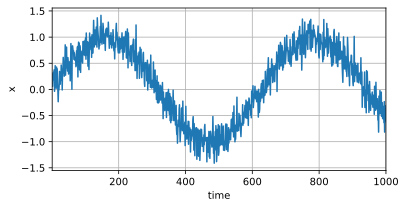

In [1]:
%matplotlib inline
import torch 
from torch import nn
from d2l import torch as d2l

T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0,0.2, (T, ))
d2l.plot(time, [x], 'time', 'x', xlim=[1,1000], figsize=(6,3))

In [2]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:,i] = x[i:T - tau + i]
labels = x[tau:].reshape((-1,1))


In [3]:
batch_size, n_train = 16, 600

train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

In [4]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                       nn.ReLU(),
                       nn.Linear(10,1))
    net.apply(init_weights)
    return net

loss = nn.MSELoss(reduction='none')

def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(),lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, loss : {d2l.evaluate_loss(net,train_iter,loss)}')
net = get_net()
train(net,train_iter, loss, 5, 0.01)

epoch 1, loss : 0.07242191662391027
epoch 2, loss : 0.05320236300428709
epoch 3, loss : 0.049713538537422816
epoch 4, loss : 0.04908483112851779
epoch 5, loss : 0.04635865665972233


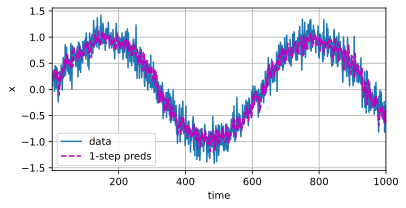

In [5]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]], [x.detach().numpy(), onestep_preds.detach().numpy()], 'time', 'x', 
         legend=['data', '1-step preds'], xlim=[1,1000], figsize=(6,3))

> 위와 같이 one-step-ahead 예측 결과는 나쁘지 않은 수준을 보여 준다.

- 문제는 특정 구간 이후 정보가 존재하지 않을 때 
- 예를 들어 604 이후 데이터가 없다면 우리는 추정 결과 값을 다시 입력의 일부로 사용하는 형식으로 즉, ```X^_605 = f(X_601, X_602, X_603, X_604)```를 통해 얻은 ```X^_605```를 다시 ```X^_606 = f(X_602, X_603, X_604, X^_605)```에 활용하는 방식으로 이후의 구간을 추정할 수 있을 것이다. 

#### K-step-ahead prediction
- X_t까지의 입력을 통하여 X_t+k를 예측하는 것


In [6]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))

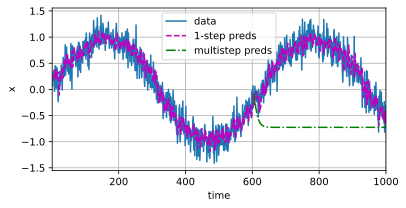

In [7]:
d2l.plot([time, time[tau:], time[n_train + tau:]], 
         [x.detach().numpy(), onestep_preds.detach().numpy(),
         multistep_preds[n_train + tau:].detach().numpy()], 'time',
        'x', legend=['data', '1-step preds', 'multistep preds'], xlim=[1,1000], figsize=(6,3))

- 입력 정보가 사실 데이터가 아닌 예측 데이터가 추가되는 시점 부터 예측의 정확도가 크게 떨어지며
- 결국 Constant로 무너져 버린다.
- 이는 예측에서 Error가 누적되는 현상에 의한 것


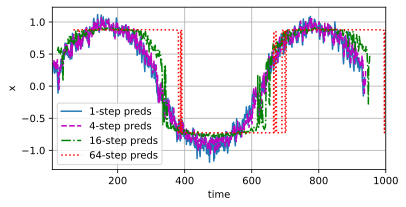

In [8]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))

for i in range(tau):
    features[:,i] = x[i: i + T - tau - max_steps + 1]

    
for i in range(tau, tau + max_steps):
    features[:,i] = net(features[:, i - tau:i]).reshape(-1)
    
steps = (1, 4, 16, 64)

d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000], 
        figsize=(6,3))

- k-step-ahead prediction의 k가 증가할 수록 prediction 성능이 떨어짐


## Text Preprocessing
- Text 데이터를 ML Model을 위해 처리하기 위해 Numerical Form으로 변환이 필요 
- Steps
  - Text를 string 데이터로 메모리에 적재
  - Token으로 분할
  - 분할 된 Token을 numerical index를 할당하여 vocabulary table을 생성
  - text를 위 table의 indices의 sequence로 변환
 


In [9]:
import collections
import re
from d2l import torch as d2l

#@save 
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt', 
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine(): #@save
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print(f'# test lines : {len(lines)}')
print(lines[0])
print(lines[10])
    

# test lines : 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


### Tokenization
- text를 일종의 기본 단위 (basic unit)을 쪼갬. 


In [10]:
def tokenize(lines, token='word'): #@save
    if token == 'word':
        return [line.split() for line in lines]
    if token == 'char':
        return [list(line) for line in lines]
    
tokens = tokenize(lines)
for i in range(10):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']


### Vocabulary
- text의 기본 단위인 token을 numerical representaion으로 변환하기 위해 구축된 dictionary
- steps
  - corpus에서 unique token을 count
  - 각 고유한 token에 numerical index를 할당 (매우 낮은 빈도의 token은 복잡도를 낮추기 위해 제거되기도 함)
  - 그리고 이렇게 제거된 token은 ```UNKNOWN```과 같은 특수한 token으로 처리됨.
  - ```PAD``` for padding,  ```BOS``` for begining of sentence, ```EOS``` for end of sentence 와 같은 특수한 목적의 token을 사용하기도 함
  
  


In [18]:
class Vocab:  #@save
    
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1], 
                                   reverse=True)
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}
        
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1
                
    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
    
    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]
    
    @property
    def unk(self):
        return 0
    
    @property
    def token_freqs(self):
        return self._token_freqs
    
    
def count_corpus(tokens):
    if len(tokens) == 0 or isinstance(tokens[0], list):
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)


        

In [20]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


In [22]:
for i in [0,10]:
    print(f'words: {tokens[i]}')
    print(f'indices : {vocab[tokens[i]]}')

words: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
indices : [1, 19, 50, 40, 2183, 2184, 400]
words: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
indices : [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


In [24]:
def load_corpus_time_machine(max_tokens=-1): #@save
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)
    

(170580, 28)

## Language Models and the dataset

- 길이가 T인 text sequence가 주어지면 임의의 token x_t는 (1 < t < T)를 만족하는 t 번째 시점의 label (불연속 시간 순서의 Sequence이므로)라고 할 때.
- Language Model은 주어진 Text Sequence을 구성하는 tokens의 joint probability ```P(x_1, x_2, ... x_T)```를 예측하는 것
- Language Model은 언어를 구성하는 이러한 joint probability를 training을 통해 습득하는 것과 같다. 
- Language Model는 임의의 입력이 주어졌을 때 이어서 나올 token을 하나씩 예측함으로써 자연스러운 문장을 만들어 내는 등 매우 유용함.

### Leraning a Language Model

- 임의의 seq (x_1,x_2,...,x_t)의 joint probability를 구하는 것으로써
```
P(x_1, x_2, ..., x_T) = product of all element for t from 1 to T( P(x_t | x_1, ..., x_t-1)
```
- 구체적인 text sequence의 예를 들면
```
P(deep, learning,is,fun) = P(deep)P(learning|deep)P(is|deep,learning)P(fun|deep,learning,is)
```

- 따라서 language model 연산을 위해 임의의 단어 조합이 주어졌을 때 특정 단어들의 조건부 확률을 계산할 수 있어야 함.

- 위 P(deep)은 deep으로 문장이 시작될 확률로 계산될 수 있다. 
- 다소 부정확하지만 더 간단하게는 데이터 내에 deep을 모두 count해서 모든 단어의 count로 나누는 방법도 있을 것이다. 
- 이러한 방법은 높은 빈도 단어에 대해서는 꽤 잘 통할 수 있는 방법일 수 있다.
- 또한 조건부 확률에 대한 Bayes' Theorem에 의해 아래와 같이 정의할 수 있다.
```
P(learning|deep) = n(deep, learning) / n(deep)
```
- 즉, P(learning|deep)은 deep, learning의 pair occurences / deep의 occurences
- 하지만 불행히도 연속된 단어 pair의 occurence를 구하는 것이 더 어려운데
  - far less frequent 하기 때문에
  - 게다가 잘 쓰이지 않는 단어 조합의 경우 더 occurence를 찾기 어렵다. 
  - 게다가 pair 뿐아니라 그 이상의 연속된 단어 조합의 occurence를 찾는 것은 더욱 어렵다.
  - 데이터셋에 존재하지 않는 연속 단어 조합(말이 되는)도 있을 수 있다. 
- 이러한 combination과 같이 빈도가 낮은 경우에 대한 적절한 해결책 없이는 language model에서 이러한 패턴들을 전혀 사용하지 못한다.
- 이에 대한 우회 방안으로써 Laplace smoothing이라는 형태의 방법을 사용할 수 있다.
- 이는 모든 단어의 빈도에 매우 작은 상수를 더해 줌으로써 낮은 빈도의 단어 패턴에 non-zero count를 부여하는 방법
- 하지만 결국 이러한 방법은 한계에 부딫히는데...
  - 모든 token에 대한 count를 저장해야 하며
  - 단어의 의미에 대한 부분을 완전히 무시한다. (통계적인 빈도의 문제로...) 
    - 예를 들어 cat과 feline은 서로 비슷한 맥락에서 사용되어야 한다. 하지만 이러한 모델에서 맥락에 대한 조정을 가하는 것은 어렵다. 
  - 긴 단어의 순열은 거의 대부분 데이터에 존재하지 않는 새로운 것들이다. 따라서 단순히 이전에 보여진 단어들의 빈도만 가지고 있는 모델은 제대로된 성능을 내지 못한다.
  



### Markov Models and n-grams
- 만약 P(x_t+1|x_t, ...,x_1) = P(x_t+1|x_t)일 경우 first order Markov property를 만족한다.
- higher order markov property의 경우 더 긴 의존성을 의미한다. 
- 이와 같이 Markov Property를 만족하는 확률 분포를 갖는 sequence를 Order에 따라 unigram, bigram, trigram, ....n-gram으로 부른다. 

### Natural Languages Statistics


[('the', 2261), ('i', 1267), ('and', 1245), ('of', 1155), ('a', 816), ('to', 695), ('was', 552), ('in', 541), ('that', 443), ('my', 440)]


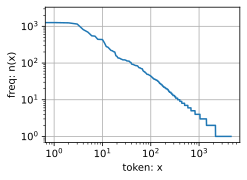

In [29]:
import random
import torch 
from d2l import torch as d2l

tokens = d2l.tokenize(d2l.read_time_machine())

corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
print(vocab.token_freqs[:10])

freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='freq: n(x)', xscale='log', yscale='log')



- 높은 빈도를 갖는 word들 대부분 매우 지루한 단어들이며 이러한 것들을 **stop word**라고 하여 종종 filter out 해버리기도 한다. 
- 10번째로 자주 등장하는 token이 제일 많이 등장하는 token의 1/5밖에 안된다.
- 빈도의 감소가 매우 급격하게 (지수) 발생됨
- Word Freq. Decay는 잘 정의된 Decay 경향을 갖는데,
- Zipf's law (?) 만족한다. (straight line in log-log plot)


In [38]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [40]:
trigram_tokens = [tri for tri in zip(corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = d2l.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

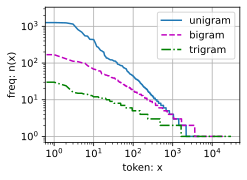

In [48]:
bigram_freqs = [freq for _,freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for _,freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], 
         xlabel='token: x', ylabel='freq: n(x)', 
         xscale='log', yscale='log', legend=['unigram', 'bigram', 'trigram'])

- unigram ~ trigram까지 비록 decay 정도는 줄어 들지만 Zipf's law를 따른다
- n-gram의 개별 count는 크지 않다.
- 많은 n-gram들의 빈도가 매우 낮다. (unigram 대비) => Laplace smoothing이 소용없다.

### Reading Long Sequence Data
- Text Sequence Data를 Nueral Network의 입력으로 넣을 때.
- 특정 Batch Size를 적용할 때 해당 batch의 offset에 따라 subsequence들이 크게 달라질 수 있는데,
- 특정 offset이 동일하게 반복되는 것은 (제일 좋은 것은 구간을 정확한 의미 단위로 나누는 것이겠지만...) 자칫 잘못된 subsequence를 학습에 사용하게 될 우려가 있다.
- 이를 해소하기 위해서 아래와 같은 방법들이 있는데...
  - Random Sampling
  - Sequential Partiioning 


#### Random Sampling
- 각 batch는 임의로 추출된다.
- 두 인접한 subsequence는 반드시 인접할 필요 없고..
- language model의 목표는 지금까지 입려된 sequence를 기반으로 next token을 맞추는 것이므로 Labels은 원래 sequence를 token 한개 만큼 shift한것이면 됨.


  


In [56]:
def seq_data_iter_random(corpus, batch_size, num_steps): #@save
    corpus = corpus[random.randint(0, num_steps - 1):]  ## give random offset
    num_subseqs = (len(corpus) - 1) // num_steps        
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    random.shuffle(initial_indices)  ## randomize possible indices for initial pos. 
    
    def data(pos):
        return corpus[pos: pos + num_steps]
    
    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        initial_indices_per_batch = initial_indices[i:i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)


In [58]:
my_seq = list(range(35))
for X,Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print(f'X: {X},\n Y: {Y}')


X: tensor([[23, 24, 25, 26, 27],
        [ 3,  4,  5,  6,  7]]),
 Y: tensor([[24, 25, 26, 27, 28],
        [ 4,  5,  6,  7,  8]])
X: tensor([[ 8,  9, 10, 11, 12],
        [28, 29, 30, 31, 32]]),
 Y: tensor([[ 9, 10, 11, 12, 13],
        [29, 30, 31, 32, 33]])
X: tensor([[13, 14, 15, 16, 17],
        [18, 19, 20, 21, 22]]),
 Y: tensor([[14, 15, 16, 17, 18],
        [19, 20, 21, 22, 23]])


#### Sequential Partitioning
- batch 내에서 원래 sequence에서 가지고 있던 sample간의 순차적 관계가 유지되도록 
- offset은 randomize 하되...


In [62]:
def seq_data_iter_sequential(corpus, batch_size, num_steps): #@save
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size ## number of tokens for each batch 
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i:i + num_steps]
        Y = Ys[:, i:i + num_steps]
        yield X,Y
    
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print(f'X: {X}\nY: {Y}')

X: tensor([[ 3,  4,  5,  6,  7],
        [18, 19, 20, 21, 22]])
Y: tensor([[ 4,  5,  6,  7,  8],
        [19, 20, 21, 22, 23]])
X: tensor([[ 8,  9, 10, 11, 12],
        [23, 24, 25, 26, 27]])
Y: tensor([[ 9, 10, 11, 12, 13],
        [24, 25, 26, 27, 28]])
X: tensor([[13, 14, 15, 16, 17],
        [28, 29, 30, 31, 32]])
Y: tensor([[14, 15, 16, 17, 18],
        [29, 30, 31, 32, 33]])


In [63]:
class SeqDataloader: #@save
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps
    
    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)
    
def load_data_time_machine(batch_size, num_steps, use_random_iter=False, max_tokens=10000): #@save
    data_iter = SeqDataloader(batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab